In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import poligrain as plg
import pykrige
import xarray as xr
from matplotlib.colors import LinearSegmentedColormap

from mergeplg import merge

In [3]:
ds_gauges = xr.open_dataset("./data/openmrg_municp_gauge.nc")
ds_cmls = xr.open_dataset("./data/openmrg_cml.nc")
ds_rad = xr.open_dataset("./data/openmrg_rad.nc")
ds_gauges_smhi = xr.open_dataset("./data/openmrg_smhi_gauge.nc")

In [4]:
# ds_rad = ds_rad.isel(y=slice(None, None, -1))

# Project data

In [5]:
# UTM32N: https://epsg.io/32632
ref_str = "EPSG:32632"

In [6]:
ds_gauges.coords["x"], ds_gauges.coords["y"] = plg.spatial.project_point_coordinates(
    ds_gauges.lon, ds_gauges.lat, ref_str
)

ds_gauges_smhi.coords["x"], ds_gauges_smhi.coords["y"] = (
    plg.spatial.project_point_coordinates(
        ds_gauges_smhi.lon, ds_gauges_smhi.lat, ref_str
    )
)

In [7]:
# For CML
(
    ds_cmls.coords["site_0_x"],
    ds_cmls.coords["site_0_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_0_lon, ds_cmls.site_0_lat, ref_str
)
(
    ds_cmls.coords["site_1_x"],
    ds_cmls.coords["site_1_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_1_lon, ds_cmls.site_1_lat, ref_str
)

# Midpoint
ds_cmls["x"] = (ds_cmls.site_0_x + ds_cmls.site_1_x) / 2
ds_cmls["y"] = (ds_cmls.site_0_y + ds_cmls.site_1_y) / 2

In [8]:
# Projected radar coords
ds_rad.coords["xs"], ds_rad.coords["ys"] = plg.spatial.project_point_coordinates(
    ds_rad.longitudes, ds_rad.latitudes, ref_str
)

In [9]:
# This is not correct, but I have to quickly create a 1D array
# for x and y with the projection that has been used above
ds_rad["x"] = ds_rad.xs.isel(y=20)
ds_rad["y"] = ds_rad.ys.isel(x=20)

## Transform CML data from `xarray.Dataset` to `pandas.DataFrame`

In [10]:
df_cmls = ds_cmls.to_dataframe().swaplevel()
df_cmls["station_id"] = df_cmls.index.get_level_values(1)
df_cmls.index = df_cmls.index.droplevel(1)
df_cmls["sensor_type"] = "cml_ericsson"
df_cmls["rainfall_amount"] = df_cmls.R
df_cmls.head(3)

,sublink_id,site_0_lat,site_0_lon,site_1_lat,site_1_lon,frequency,polarization,length,quantile,R,site_0_x,site_0_y,site_1_x,site_1_y,x,y,station_id,sensor_type,rainfall_amount
time,,,,,,,,,,,,,,,,,,,
2015-07-25 12:30:00,sublink_1,57.70368,11.99507,57.69785,11.9911,28206.5,v,691.44,0.8,0.081734,678461.430339,6.399665e+06,678253.619459,6.399006e+06,678357.524899,6.399335e+06,10001,cml_ericsson,0.081734
2015-07-25 12:35:00,sublink_1,57.70368,11.99507,57.69785,11.9911,28206.5,v,691.44,0.8,0.116602,678461.430339,6.399665e+06,678253.619459,6.399006e+06,678357.524899,6.399335e+06,10001,cml_ericsson,0.116602
2015-07-25 12:40:00,sublink_1,57.70368,11.99507,57.69785,11.9911,28206.5,v,691.44,0.8,0.153880,678461.430339,6.399665e+06,678253.619459,6.399006e+06,678357.524899,6.399335e+06,10001,cml_ericsson,0.153880


In [11]:
from mergeplg import radolan

In [12]:
# x_grid, y_grid = np.meshgrid(ds_rad.x.values, ds_rad.y.values)

intersection_weights = plg.spatial.calc_sparse_intersect_weights_for_several_cmls(
    x1_line=ds_cmls.site_0_x.values,
    y1_line=ds_cmls.site_0_y.values,
    x2_line=ds_cmls.site_1_x.values,
    y2_line=ds_cmls.site_1_y.values,
    cml_id=ds_cmls.cml_id.values,
    x_grid=ds_rad.xs.data,
    y_grid=ds_rad.ys.data,
    grid_point_location="lower_left",
)

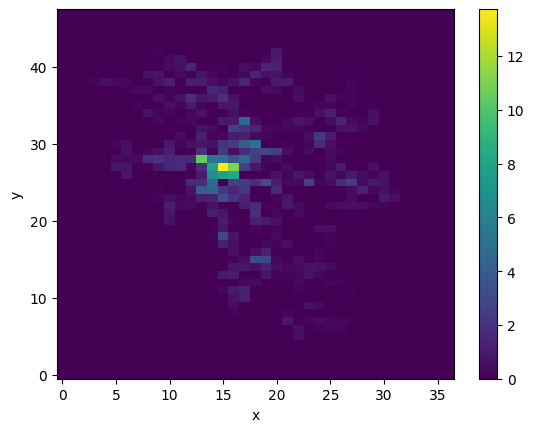

In [13]:
intersection_weights.sum(dim="cml_id").plot();

In [14]:
# need to set this variable since my old code starts with this
ds_rad["RH"] = ds_rad.rainfall_amount

In [15]:
ds_radolan_t_list = []
df_stations_t_list = []
for t in ds_rad.time.data:
    ds_radolan_t, df_stations_t = radolan.processing.rh_to_rw(
        ds_radolan_t=ds_rad.sel(time=t),
        df_stations_t=df_cmls.loc[t, :],
        allow_gauge_and_cml=True,
        intersect_weights=intersection_weights,
        max_distance=30e3,
    )
    ds_radolan_t_list.append(ds_radolan_t)
    df_stations_t_list.append(df_stations_t)

In [16]:
ds_radolan = xr.concat(ds_radolan_t_list, dim="time")
ds_radolan

<xarray.Dataset> Size: 9MB
Dimensions:                      (time: 31, y: 48, x: 37)
Coordinates:
  * time                         (time) datetime64[ns] 248B 2015-07-25T12:30:...
  * x                            (x) float64 296B 6.461e+05 ... 7.174e+05
  * y                            (y) float64 384B 6.346e+06 ... 6.439e+06
    xs                           (y, x) float64 14kB 6.457e+05 ... 7.157e+05
    ys                           (y, x) float64 14kB 6.343e+06 ... 6.441e+06
Data variables: (12/22)
    crs                          (time) int32 124B 1 1 1 1 1 1 1 ... 1 1 1 1 1 1
    latitudes                    (time, y, x) float32 220kB 57.21 ... 58.06
    longitudes                   (time, y, x) float32 220kB 11.41 ... 12.66
    rainfall_amount              (time, y, x) float64 440kB 0.01078 ... 0.05403
    RH                           (time, y, x) float64 440kB 0.01078 ... 0.05403
    RG                           (time, y, x) float64 440kB 0.01078 ... 0.05403
    ...                           ...
    mulfak_relevant              (time, y, x) float64 440kB 0.01078 ... 0.05403
    RW_not_rounded               (time, y, x) float64 440kB 0.01078 ... 0.05403
    RW                           (time, y, x) float64 440kB 0.0 0.0 ... 0.0 0.0
    RW_interim                   (time, y, x) float64 440kB 0.01078 ... 0.05403
    RR                           (time, y, x) float64 440kB nan nan ... nan nan
    RW_no_station_fill           (time, y, x) float64 440kB 0.0 0.0 ... 0.0 0.0
Attributes:
    source:       Swedish Meteorological and Hydrological Institute (SMHI), H...
    contact:      hydro.fou@smhi.se, remco.vandebeek@smhi.se
    title:        OpenMRG-Radar
    license:      https://creativecommons.org/licenses/by-sa/4.0
    version:      1.1
    doi:          https://doi.org/10.5281/zenodo.6673750
    proj_string:  +proj=stere +lat_ts=60 +ellps=bessel +lon_0=14 +lat_0=90
    comment:      Created by Remco van de Beek, Victor Näslund and Johan Thur...

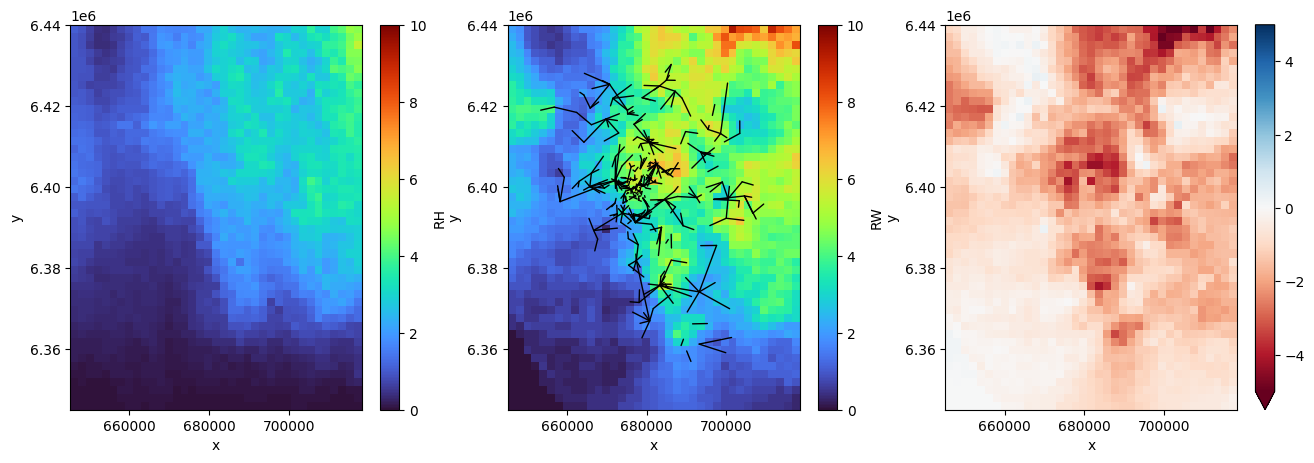

In [17]:
vmin, vmax = 0, 10
cmap = "turbo"
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
ds_radolan.sum(dim="time").RH.plot(ax=axs[0], vmin=vmin, vmax=vmax, cmap=cmap)
ds_radolan.sum(dim="time").RW.plot(ax=axs[1], vmin=vmin, vmax=vmax, cmap=cmap)
(ds_radolan.sum(dim="time").RH - ds_radolan.sum(dim="time").RW).plot(
    ax=axs[2],
    vmin=-5,
    vmax=5,
    cmap="RdBu",
)

plg.plot_map.scatter_lines(
    x0=ds_cmls.site_0_x,
    x1=ds_cmls.site_1_x,
    y0=ds_cmls.site_0_y,
    y1=ds_cmls.site_1_y,
    ax=axs[1],
    s=1,
    c="k",
)

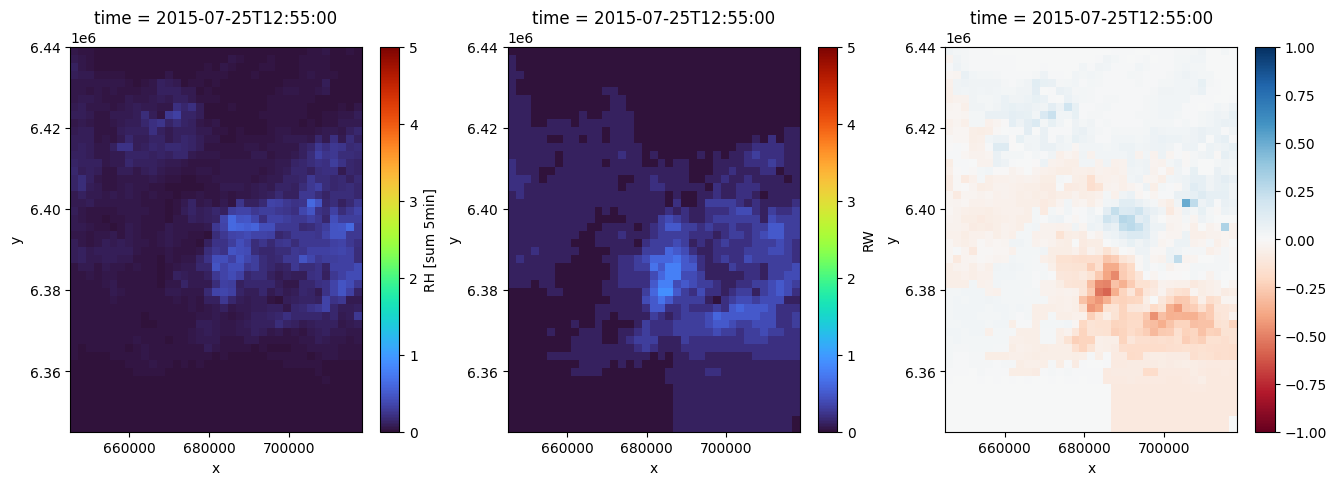

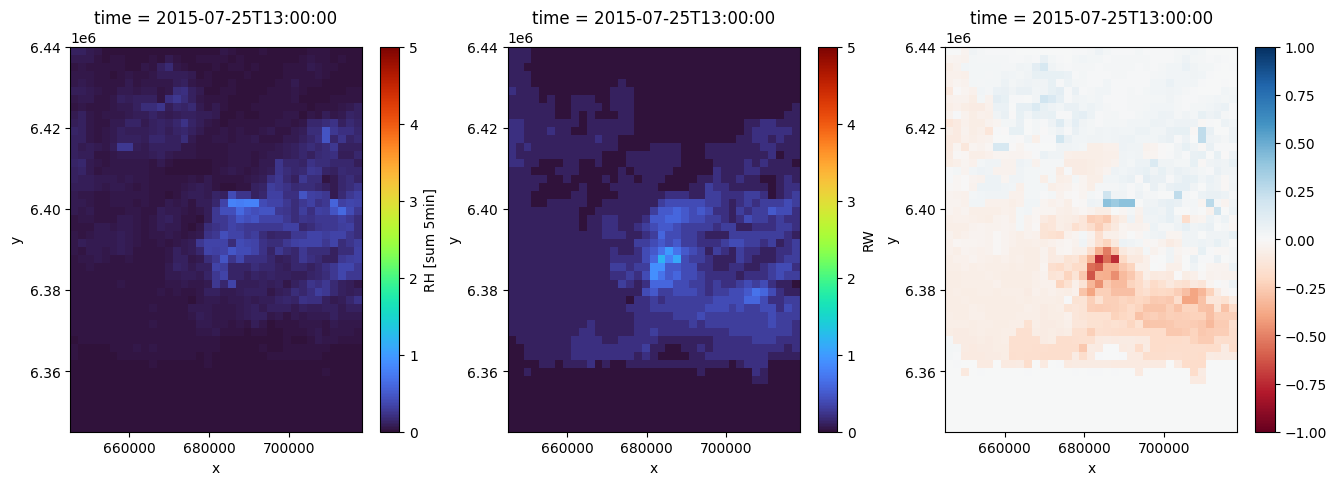

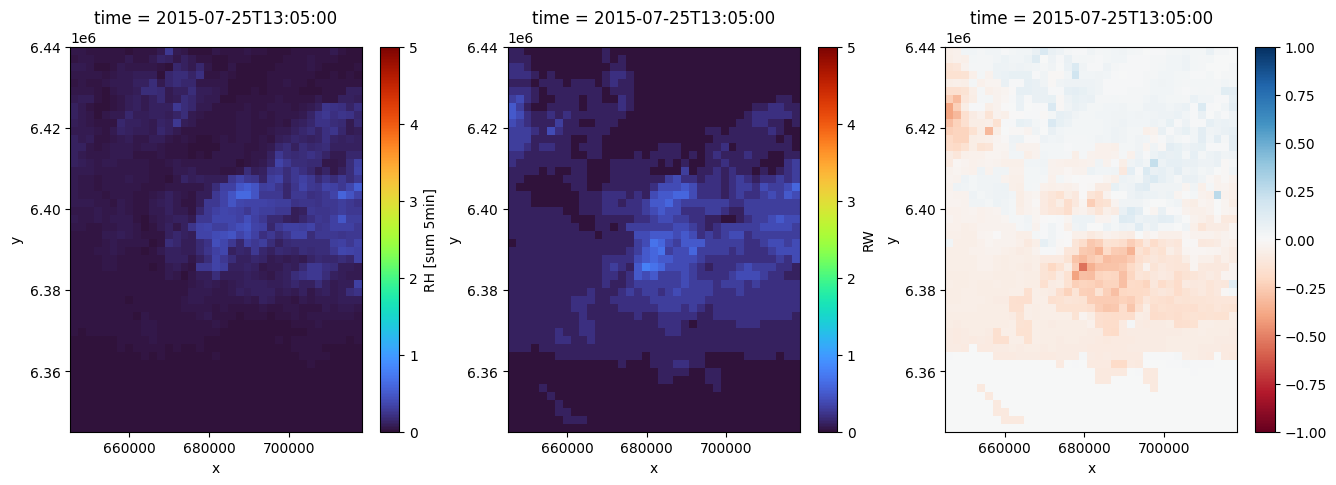

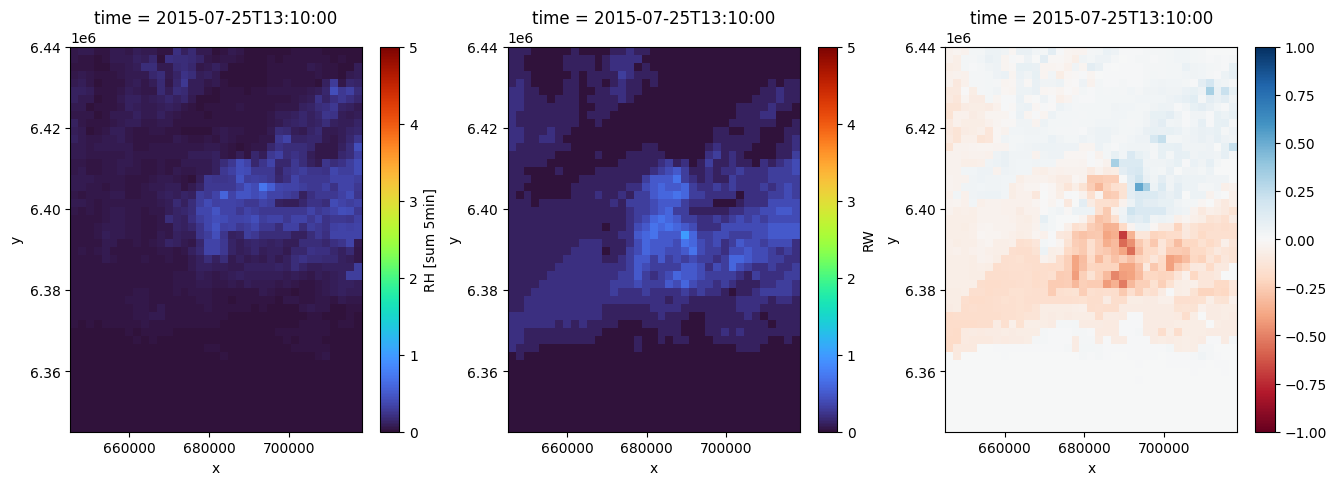

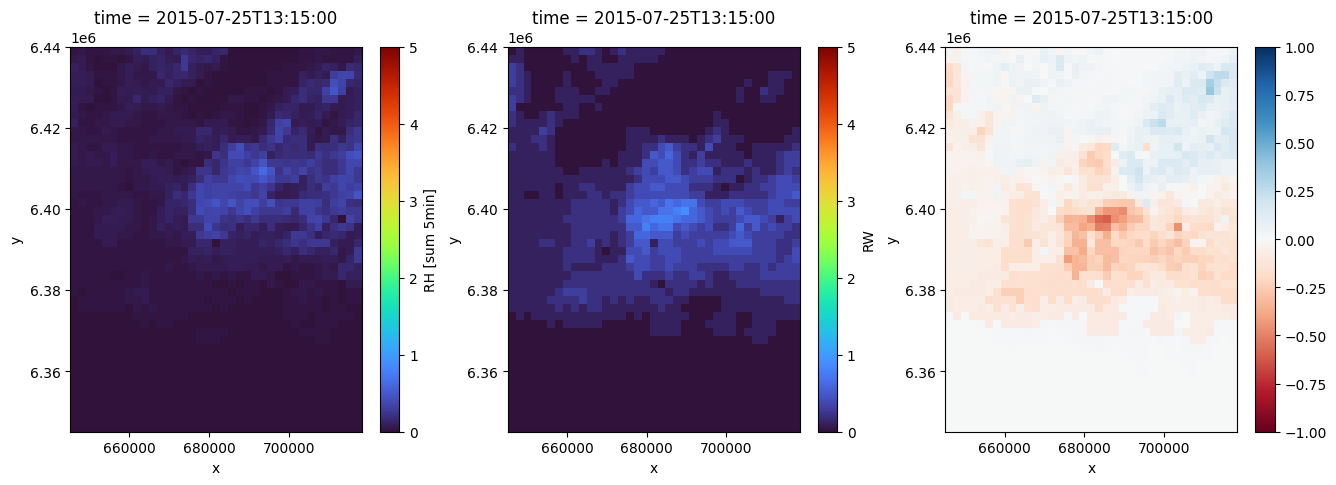

In [18]:
for t in ds_radolan.time.data[5:10]:
    vmin, vmax = 0, 5
    cmap = "turbo"
    fig, axs = plt.subplots(1, 3, figsize=(16, 5))
    ds_radolan.sel(time=t).RH.plot(ax=axs[0], vmin=vmin, vmax=vmax, cmap=cmap)
    ds_radolan.sel(time=t).RW.plot(ax=axs[1], vmin=vmin, vmax=vmax, cmap=cmap)
    (ds_radolan.sel(time=t).RH - ds_radolan.sel(time=t).RW).plot(
        ax=axs[2],
        vmin=-1,
        vmax=1,
        cmap="RdBu",
    )

# Dev of tests

In [98]:
# df_stations = pd.read_csv("../../tests/test_data/radolan_rain_gauge_data.csv")
# df_stations = df_stations[616:1828]
# df_stations = df_stations[~df_stations.station_id.str.contains("PL")]
# # df_stations

In [103]:
df_stations = pd.read_csv(
    "../../tests/test_data/radolan_rain_gauge_data.csv", index_col=1
)
df_stations.head()

,time,station_id,rainfall_amount,station_name,longitude,latitude,x,y
Unnamed: 0,,,,,,,,
616,2021-08-23 09:50:00,A051,0.0,Weesby,9.148056,54.837222,-56.001728,-3766.004001
617,2021-08-23 09:50:00,A112,0.0,Wrixum/F�hr,8.527222,54.692778,-97.228436,-3781.664924
618,2021-08-23 09:50:00,A138,0.0,Bordelum,8.936944,54.632778,-70.310674,-3789.117674
619,2021-08-23 09:50:00,A159,0.0,Eggebek,9.365000,54.628333,-42.006186,-3790.045077
620,2021-08-23 09:50:00,A173,0.0,Satrup,9.626111,54.685278,-24.691174,-3783.690843


In [104]:
ds_radolan = xr.open_dataset("../../tests/test_data/radolan_ry_data_compressed.nc")

In [105]:
RY_sum = ds_radolan.RY.sum(dim="time", min_count=12)

## test rh_to_rw

In [106]:
RY_sum = ds_radolan.RY.sum(dim="time", min_count=12).to_dataset(name="RH")
RY_sum["time"] = ds_radolan.time.values[-1] + pd.Timedelta("5min")

ds_radolan_result, df_stations_result = radolan.processing.rh_to_rw(
    ds_radolan_t=RY_sum,
    df_stations_t=df_stations,
    idw_method="radolan",
    start_index_in_relevant_stations=0,
    nnear=20,
    max_distance=60,
)

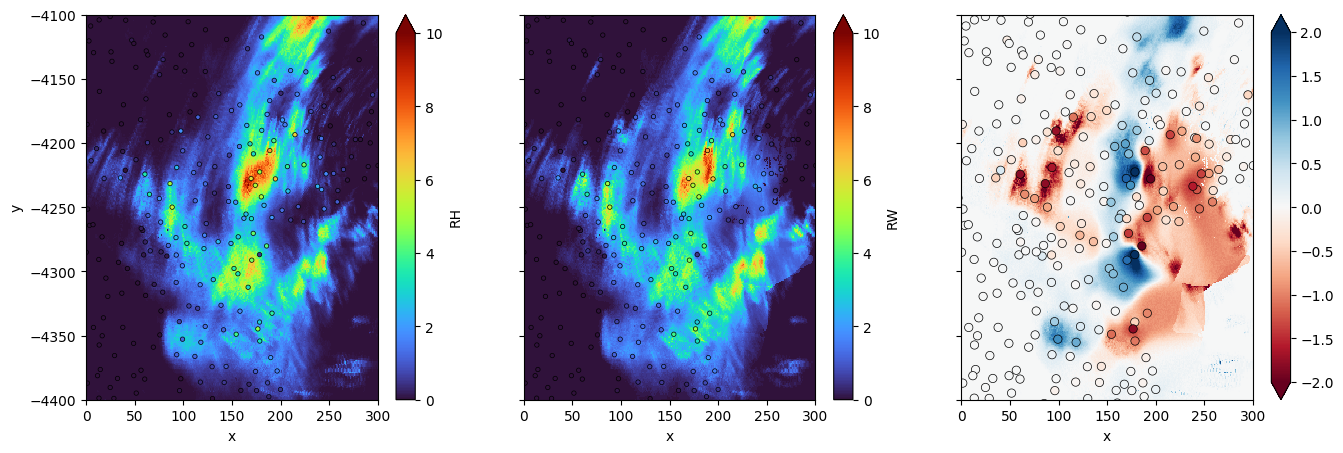

In [143]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5), sharex=True, sharey=True)
ds_radolan_result.RH.plot(vmax=10, cmap='turbo', ax=axs[0]);
df_stations_result.plot.scatter('x', 'y', c='rainfall_amount', vmax=10, cmap='turbo', ax=axs[0], s=10, colorbar=False, edgecolor='k', linewidth=0.5);
ds_radolan_result.RW.plot(vmax=10, cmap='turbo', ax=axs[1]);
df_stations_result.plot.scatter('x', 'y', c='rainfall_amount', vmax=10, cmap='turbo', ax=axs[1], s=10, colorbar=False, edgecolor='k', linewidth=0.5);
(ds_radolan_result.RH - ds_radolan_result.RW).plot(vmin=-2, vmax=2, cmap='RdBu', ax=axs[2]);
axs[2].scatter(
    df_stations_result.x,
    df_stations_result.y,
    c=(df_stations_result.radar_RB_rainfall - df_stations_result.rainfall_amount),
    vmin=-2, vmax=2, cmap='RdBu',
    edgecolor='k', linewidth=0.5,
)

axs[0].set_xlim(0, 300)
axs[0].set_ylim(-4400, -4100);

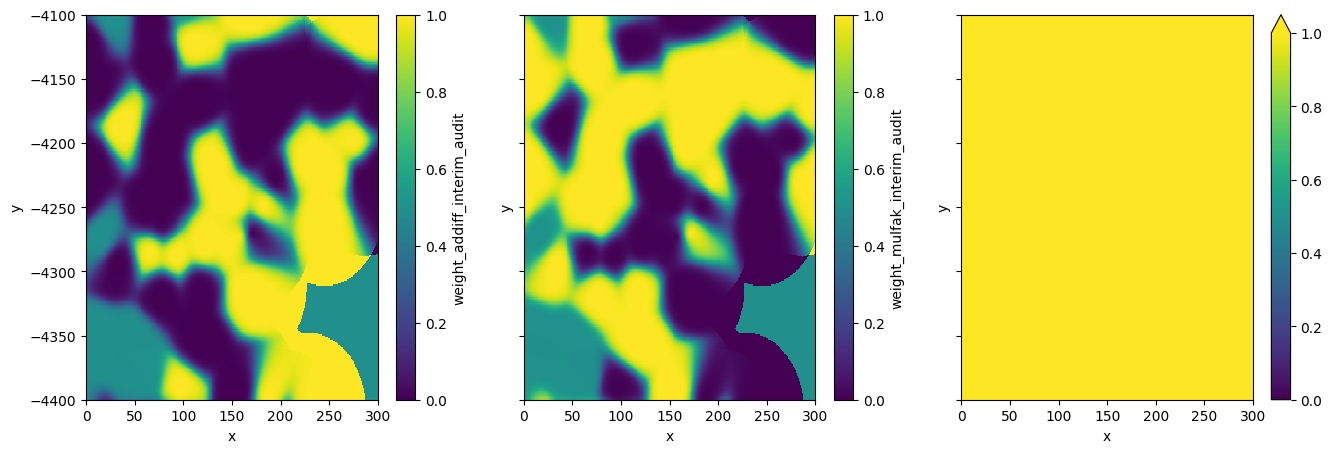

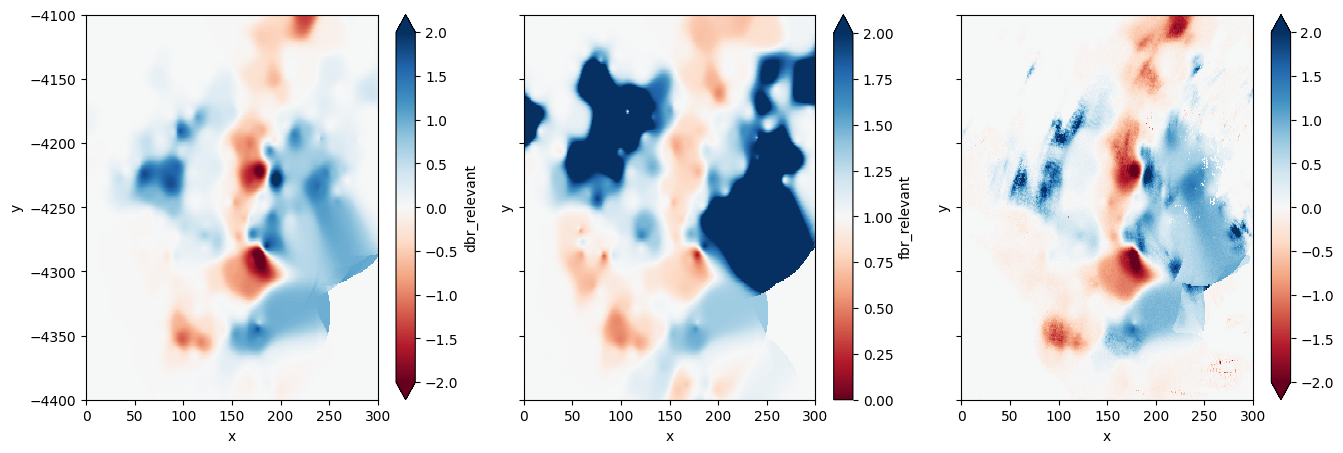

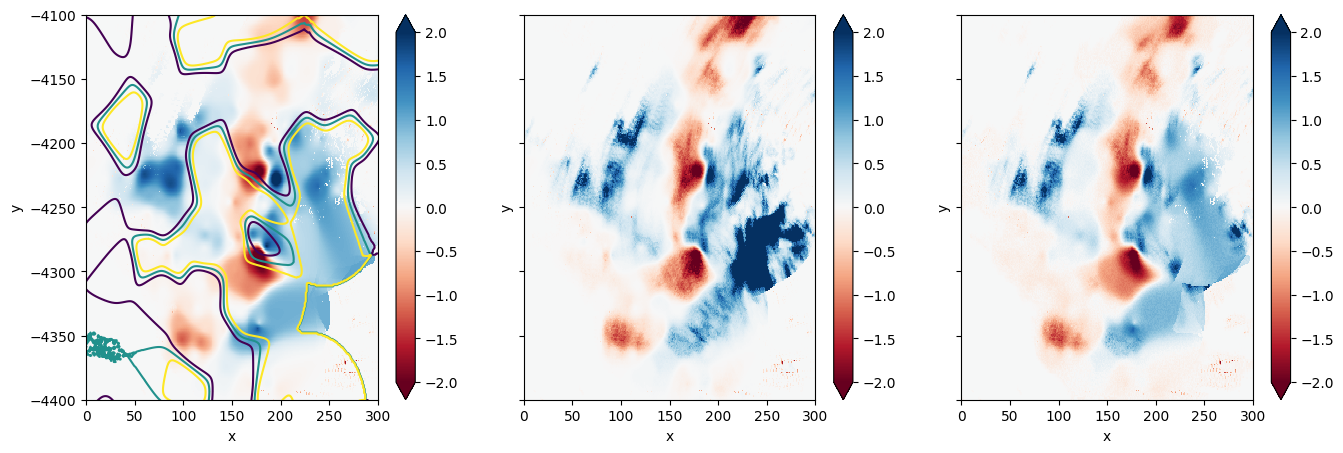

In [174]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5), sharex=True, sharey=True)

ds_radolan_result.weight_addiff_interim_audit.plot(ax=axs[0])
ds_radolan_result.weight_mulfak_interim_audit.plot(ax=axs[1])
(
    (ds_radolan_result.weight_addiff_interim_audit + ds_radolan_result.weight_mulfak_interim_audit)
    .plot(ax=axs[2], vmin=0, vmax=1)
)

axs[0].set_xlim(0, 300)
axs[0].set_ylim(-4400, -4100);


fig, axs = plt.subplots(1, 3, figsize=(16, 5), sharex=True, sharey=True)

ds_radolan_result.dbr_relevant.plot(ax=axs[0], vmin=-2, vmax=2, cmap='RdBu')
ds_radolan_result.fbr_relevant.plot(ax=axs[1], vmin=0, vmax=2, cmap='RdBu')
(ds_radolan_result.RW - ds_radolan_result.RH).plot(vmin=-2, vmax=2, cmap='RdBu', ax=axs[2]);

axs[0].set_xlim(0, 300)
axs[0].set_ylim(-4400, -4100);

fig, axs = plt.subplots(1, 3, figsize=(16, 5), sharex=True, sharey=True)

(ds_radolan_result.addiff_relevant - ds_radolan_result.RH).plot(vmin=-2, vmax=2, cmap='RdBu', ax=axs[0]);
(ds_radolan_result.mulfak_relevant - ds_radolan_result.RH).plot(vmin=-2, vmax=2, cmap='RdBu', ax=axs[1]);
(ds_radolan_result.RW - ds_radolan_result.RH).plot(vmin=-2, vmax=2, cmap='RdBu', ax=axs[2]);

ds_radolan_result.weight_addiff_interim_audit.plot.contour(levels=[0.2, 0.5, 0.8], ax=axs[0])


axs[0].set_xlim(0, 300)
axs[0].set_ylim(-4400, -4100);

In [171]:
ds_radolan_result

<xarray.Dataset> Size: 123MB
Dimensions:                      (x: 900, y: 900)
Coordinates:
  * x                            (x) float64 7kB -523.5 -522.5 ... 374.5 375.5
  * y                            (y) float64 7kB -4.659e+03 ... -3.76e+03
    longitude                    (y, x) float32 3MB 3.589 3.601 ... 15.69 15.7
    latitude                     (y, x) float32 3MB 46.95 46.95 ... 54.73 54.73
Data variables: (12/19)
    RH                           (y, x) float64 6MB nan nan nan ... nan nan nan
    time                         datetime64[ns] 8B 2021-08-23T09:50:00
    RG                           (y, x) float64 6MB nan nan nan ... nan nan nan
    RB                           (y, x) float64 6MB nan nan nan ... nan nan nan
    dbr_interim                  (y, x) float64 6MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    fbr_interim                  (y, x) float64 6MB 1.0 1.0 1.0 ... 1.0 1.0 1.0
    ...                           ...
    mulfak_relevant              (y, x) float64 6MB nan nan nan ... nan nan nan
    RW_not_rounded               (y, x) float64 6MB nan nan nan ... nan nan nan
    RW                           (y, x) float64 6MB nan nan nan ... nan nan nan
    RW_interim                   (y, x) float64 6MB nan nan nan ... nan nan nan
    RR                           (y, x) float64 6MB nan nan nan ... nan nan nan
    RW_no_station_fill           (y, x) float64 6MB nan nan nan ... nan nan nan

Look at region that was tested in original pyRADOLAN tests

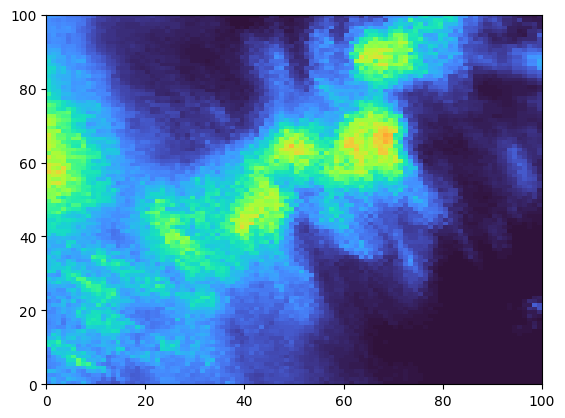

In [112]:
plt.pcolormesh(RY_sum.RH.data[300:400, 700:800], vmax=10, cmap='turbo');

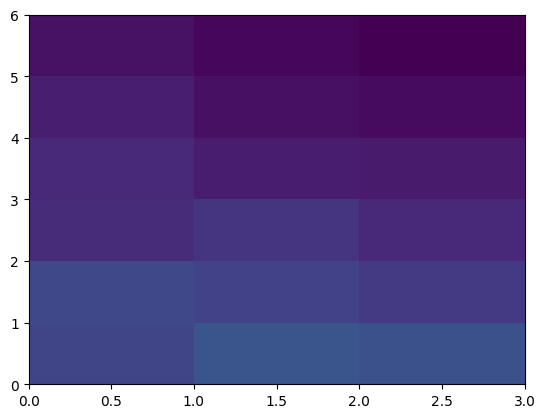

In [114]:
plt.pcolormesh(RY_sum.RH.data[369:375, 747:750], vmax=10)

## test check radar coverage

In [ ]:
import mergeplg as mrg

# ds_radolan, df_stations = get_test_data()
RY_sum = ds_radolan.RY.sum(dim="time", min_count=12)

no_radar_coverage = mrg.radolan.adjust.check_for_radar_coverage(
    x_gage=[-1500, -350, -350, 100],
    y_gage=[-4500, -4500, -4300, -4300],
    x_radar=RY_sum.x.values.flatten(),
    y_radar=RY_sum.y.values.flatten(),
    no_radar_coverage_grid=RY_sum.isnull().values,  # noqa: PD003
)

np.testing.assert_equal(
    no_radar_coverage,
    np.array([True, True, False, False]),
)

## test label interim

In [ ]:
RY_sum = ds_radolan.RY.sum(dim="time", min_count=12)

df_stations_with_audit_interim = (
    mrg.radolan.adjust.label_relevant_audit_interim_in_gageset(
        df_gageset_t=df_stations,
        da_radolan=RY_sum,
        start_index_in_relevant=2,
    )
)

assert df_stations_with_audit_interim.audit.sum() == 228
assert df_stations_with_audit_interim.interim.sum() == 914
assert (
    df_stations_with_audit_interim[
        df_stations_with_audit_interim.audit
    ].station_id.iloc[101]
    == "L521"
)

# Test with random start index
audit_station_id_previous = None
N_random_runs = 5
for i in range(N_random_runs):
    # Note that the defaul for start_index_in_relevant='random', hence we do not set it here
    df_stations_with_audit_interim = (
        mrg.radolan.adjust.label_relevant_audit_interim_in_gageset(
            df_gageset_t=df_stations,
            da_radolan=RY_sum,
        )
    )
    audit_station_id = df_stations_with_audit_interim[
        df_stations_with_audit_interim.audit
    ].station_id.iloc[99]

    if audit_station_id_previous is None:
        audit_station_id_previous = audit_station_id
        continue
    elif audit_station_id != audit_station_id_previous:
        break
    else:
        audit_station_id_previous = audit_station_id
        continue
# This fails if all runs with random start index produced the same station_id
assert i < N_random_runs - 1


with pytest.raises(TypeError):
    mrg.radolan.adjust.label_relevant_audit_interim_in_gageset(
        df_gageset_t=df_stations,
        da_radolan=RY_sum,
        start_index_in_relevant=1.42,
    )

In [ ]:
fig, ax = plt.subplots()

df_stations_with_audit_interim[
    df_stations_with_audit_interim.audit == True
].plot.scatter("x", "y", color="r", ax=ax)
df_stations_with_audit_interim[
    df_stations_with_audit_interim.interim == True
].plot.scatter("x", "y", ax=ax)

In [ ]:
df_stations_with_audit_interim.audit.sum()

In [ ]:
df_stations_with_audit_interim.interim.sum()

In [ ]:
len(df_stations_with_audit_interim)

In [ ]:
df_stations_with_audit_interim[df_stations_with_audit_interim.audit].station_id.iloc[
    101
]

## test get grid rainfall at points

In [ ]:
df_stations["radar_at_gauge"] = mrg.radolan.adjust.get_grid_rainfall_at_points(
    RY_sum,
    df_stations,
)
np.testing.assert_array_almost_equal(
    df_stations.sort_values("radar_at_gauge").radar_at_gauge.values[-10:],
    np.array([4.69, 4.75, 4.76, 4.89, 5.73, 5.99, 6.39, 7.3, 7.57, 7.57]),
)
np.testing.assert_array_equal(
    df_stations.sort_values("radar_at_gauge").station_id.values[-5:],
    np.array(["O980", "O811", "M500", "F598", "O708"], dtype=object),
)

In [ ]:
RY_sum.plot()
plt.scatter(
    df_stations.x,
    df_stations.y,
    c=df_stations.radar_at_gauge,
    s=5,
)

In [ ]:
df_stations.sort_values("radar_at_gauge").station_id.values[-5:]

## test interpolate station values

In [ ]:
interpolated_grid = mrg.radolan.adjust.interpolate_station_values(
    df_stations=df_stations,
    col_name="rainfall_amount",
    ds_grid=RY_sum,
    nnear=8,
    p=2,
    max_distance=60,
    idw_method="standard",
)
np.testing.assert_array_almost_equal(
    interpolated_grid.values[410:414, 710:714],
    np.array(
        [
            [2.72487096, 2.800001, 2.83147212, 2.82727883],
            [2.80509236, 2.88496315, 2.92157422, 2.92241554],
            [2.94312663, 3.00469669, 3.03208744, 3.02933747],
            [3.13244699, 3.15721331, 3.16299551, 3.14901499],
        ]
    ),
)

interpolated_grid = mrg.radolan.adjust.interpolate_station_values(
    df_stations=df_stations,
    col_name="rainfall_amount",
    ds_grid=RY_sum,
    nnear=8,
    p=2,
    max_distance=60,
    idw_method="radolan",
)
np.testing.assert_array_almost_equal(
    interpolated_grid.values[410:414, 710:714],
    np.array(
        [
            [2.68921691, 2.6993467, 2.67471823, 2.61990556],
            [2.78720804, 2.8033063, 2.78501507, 2.73558897],
            [2.93226004, 2.93803843, 2.91615941, 2.86679836],
            [3.12492011, 3.10614845, 3.07118028, 3.01634675],
        ]
    ),
)

# test filling of NaNs (first check that NaNs are there and then do interpolation
# again with filled NaNs)
nan = np.nan
np.testing.assert_array_almost_equal(
    interpolated_grid.values[355:359, 800:804],
    np.array(
        [
            [nan, nan, nan, nan],
            [1.02, 1.02, nan, nan],
            [1.23399745, 1.02, 1.02, 1.02],
            [1.23115475, 1.22518546, 1.21935005, 1.02],
        ]
    ),
)

interpolated_grid = mrg.radolan.adjust.interpolate_station_values(
    df_stations=df_stations,
    col_name="rainfall_amount",
    ds_grid=RY_sum,
    nnear=8,
    p=2,
    max_distance=60,
    idw_method="radolan",
    fill_value=0,
)
np.testing.assert_array_almost_equal(
    interpolated_grid.values[355:359, 800:804],
    np.array(
        [
            [0, 0, 0, 0.0],
            [1.02, 1.02, 0, 0],
            [1.23399745, 1.02, 1.02, 1.02],
            [1.23115475, 1.22518546, 1.21935005, 1.02],
        ]
    ),
)

In [ ]:
interpolated_grid.plot()

In [ ]:
interpolated_grid[355:359, 800:804]

## test BOGRA

In [ ]:
# Test with xarray.DataArray
smoothed_data = mrg.radolan.adjust.bogra_like_smoothing(RY_sum)
np.testing.assert_array_almost_equal(
    (smoothed_data - RY_sum).values[138:142, 679:682],
    np.array(
        [
            [0.0, 0.0, -0.03349609],
            [0.0, -1.08796875, 0.0],
            [-0.2034375, -0.99517578, 0.0],
            [0.0, 0.0, -0.32083984],
        ],
    ),
)

# Test again, but with different threshold
smoothed_data = mrg.radolan.adjust.bogra_like_smoothing(
    RY_sum,
    max_allowed_relative_diff=5,
)
np.testing.assert_array_almost_equal(
    (smoothed_data - RY_sum).values[138:142, 679:682],
    np.array(
        [
            [0.0, 0.0, 0.0],
            [0.0, -0.98375, 0.0],
            [0.0, -0.83375, 0.0],
            [0.0, 0.0, 0.0],
        ],
    ),
)

# Test again, but with high threshold and less iterations, just to check
# that the `break` in the bogra loop is called.
smoothed_data = mrg.radolan.adjust.bogra_like_smoothing(
    RY_sum, max_allowed_relative_diff=10, max_iterations=10
)
np.testing.assert_array_almost_equal(
    (smoothed_data - RY_sum).values[138:142, 679:682],
    np.array(
        [
            [0.0, 0.0, 0.0],
            [0.0, 0, 0.0],
            [0.0, 0, 0.0],
            [0.0, 0.0, 0.0],
        ],
    ),
)

# Test that resutls are the same for numpy array xarray.DataArray as input
np.testing.assert_array_almost_equal(
    mrg.radolan.adjust.bogra_like_smoothing(RY_sum).values,
    mrg.radolan.adjust.bogra_like_smoothing(RY_sum.values),
)